In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import zipfile
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image, ImageFile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')
# Change the working directory to a folder in your Google Drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/CombinedImages')

# Confirm the working directory has been changed
print("Current Working Directory: ", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory:  /content/drive/MyDrive/Colab Notebooks/CombinedImages


In [12]:
!ls

Data  Final_VGGNet_final_model.ipynb  Final_VGGNet.ipynb  Final_VGGNet_ray_tuner.ipynb


## Load Dataset: Unable to Download Due to Restrictions/Error

# Load and Display Images (Loading dataset from Google Drive)




In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size required by the model
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='Data/', transform=transform)



# Define the proportions for train, val, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

print(train_size, val_size, test_size)



1492 319 321


In [14]:
from torch.utils.data import DataLoader, random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Prepare Data for PyTorch

# Define VGGNet Model

In [15]:
# Define VGGNet model
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Train and Test the model

In [ ]:
# Instantiate model, define loss and optimizer
model = VGGNet(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=01e-4, momentum=0.9)
save_path = '/content/drive/MyDrive/Colab Notebooks/CombinedImages'



# Training function
def train_model(model, traindataloader, testdataloader, criterion, optimizer, num_epochs=25):
    history = {'train loss': [], 'train accuracy': [], 'val loss': [], 'val accuracy': []}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in traindataloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      epoch_loss = running_loss / len(traindataloader.dataset)
      epoch_accuracy = 100 * correct / total
      history['train loss'].append(epoch_loss)
      history['train accuracy'].append(epoch_accuracy)
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

      model.eval()  # Set the model to evaluation mode
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in testdataloader:
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * inputs.size(0)

              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_epoch_loss = val_loss / len(testdataloader.dataset)
      val_epoch_accuracy = 100 * correct / total
      history['val loss'].append(val_epoch_loss)
      history['val accuracy'].append(val_epoch_accuracy)
      print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%')

      # Check if this is the best validation loss so far
      if val_epoch_loss < best_val_loss:
          best_val_loss = val_epoch_loss
          save_filename = os.path.join(save_path, 'best_model.pth')
          torch.save(model.state_dict(), 'best_model.pth')
          print(f'Best model saved with Val Loss: {best_val_loss:.4f}')

    return model, history



# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train and test the model

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)




Epoch 1/25, Train Loss: 0.6922, Train Accuracy: 56.97%
Epoch 1/25, Val Loss: 0.6905, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6905
Epoch 2/25, Train Loss: 0.6899, Train Accuracy: 60.05%
Epoch 2/25, Val Loss: 0.6881, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6881
Epoch 3/25, Train Loss: 0.6877, Train Accuracy: 60.05%
Epoch 3/25, Val Loss: 0.6858, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6858
Epoch 4/25, Train Loss: 0.6857, Train Accuracy: 60.05%
Epoch 4/25, Val Loss: 0.6838, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6838
Epoch 5/25, Train Loss: 0.6842, Train Accuracy: 60.05%
Epoch 5/25, Val Loss: 0.6819, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6819
Epoch 6/25, Train Loss: 0.6828, Train Accuracy: 60.05%
Epoch 6/25, Val Loss: 0.6803, Val Accuracy: 61.44%
Best model saved with Val Loss: 0.6803
Epoch 7/25, Train Loss: 0.6817, Train Accuracy: 60.05%
Epoch 7/25, Val Loss: 0.6790, Val Accuracy: 61.44%
Best model saved with Va

# Plot data

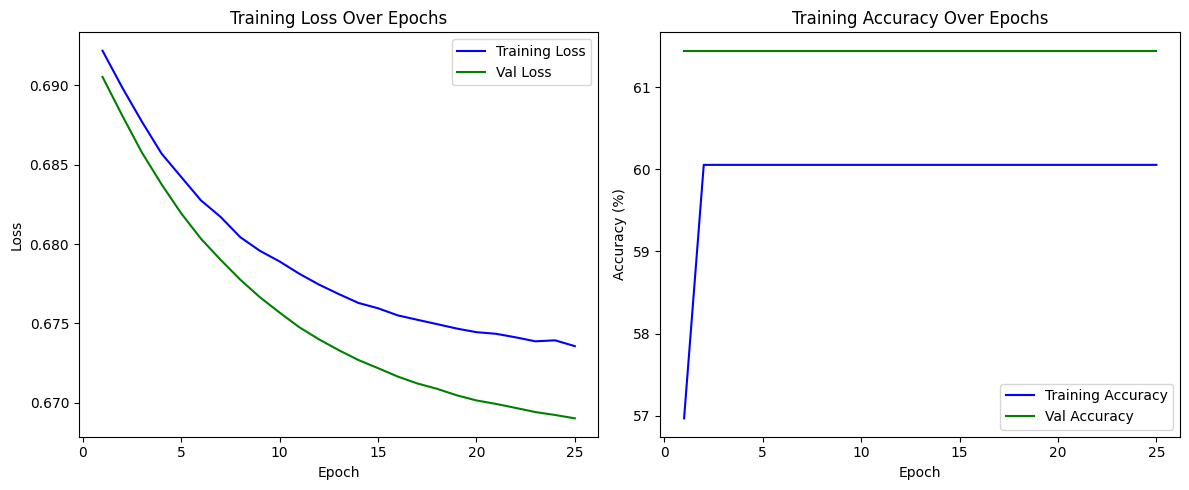

In [19]:
def plot_training_history(history):
    """Plot training loss and accuracy over epochs."""
    epochs = range(1, len(history['train loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val loss'], 'g-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val accuracy'], 'g-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(history)

### Test on TestLoader

In [20]:
# Load the best model
best_model = model  # Create a new model instance if necessary
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

# Evaluate the best model on the test data
best_model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_epoch_loss = test_loss / len(test_loader.dataset)
test_epoch_accuracy = 100 * correct / total
print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%')

<ipython-input-20-a544e0fcd015>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.6815, Test Accuracy: 57.63%


Predicted: 1, Actual: 1


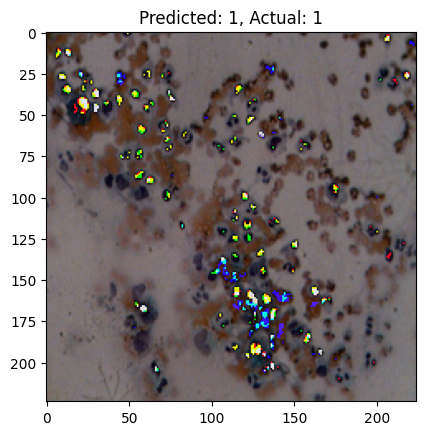

In [21]:
# Get a single image and label from the test dataset
test_iter = iter(test_loader)
inputs, labels = next(test_iter)
inputs, labels = inputs.to(device), labels.to(device)

# Evaluate the model on this single image
with torch.no_grad():
    output = best_model(inputs[0].unsqueeze(0))  # Unsqueeze to add batch dimension
    _, predicted = torch.max(output, 1)

# Print the prediction and the actual label
print(f'Predicted: {predicted.item()}, Actual: {labels[0].item()}')

# Optionally, display the image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Convert tensor to PIL image for visualization (assuming inputs are normalized)
inv_normalize = transforms.Normalize(
    mean=[-0.485, -0.456, -0.406],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img = inv_normalize(inputs[0].cpu())
img = transforms.ToPILImage()(img)

plt.imshow(img)
plt.title(f'Predicted: {predicted.item()}, Actual: {labels[0].item()}')
plt.show()